In [12]:
# ====================
# 1. Import Libraries
# ====================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ====================
# 2. Load the Dataset
# ====================

# Replace this with the correct path to your dataset file
df = pd.read_csv('/kaggle/input/bank-transaction-fraud-detection/Bank_Transaction_Fraud_Detection.csv')

# Inspect the first few rows
df.head()


,Customer_ID,Customer_Name,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,...,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Customer_Contact,Transaction_Description,Customer_Email
0,d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e,Osha Tella,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,...,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,+9198579XXXXXX,Bitcoin transaction,oshaXXXXX@XXXXX.com
1,7c14ad51-781a-4db9-b7bd-67439c175262,Hredhaan Khosla,Female,51,Maharashtra,Nashik,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,...,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,+9191074XXXXXX,Grocery delivery,hredhaanXXXX@XXXXXX.com
2,3a73a0e5-d4da-45aa-85f3-528413900a35,Ekani Nazareth,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,...,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,+9197745XXXXXX,Mutual fund investment,ekaniXXX@XXXXXX.com
3,7902f4ef-9050-4a79-857d-9c2ea3181940,Yamini Ramachandran,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,...,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,+9195889XXXXXX,Food delivery,yaminiXXXXX@XXXXXXX.com
4,3a4bba70-d9a9-4c5f-8b92-1735fd8c19e9,Kritika Rege,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,...,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,+9195316XXXXXX,Debt repayment,kritikaXXXX@XXXXXX.com


Shape of the dataset: (200000, 24)

Data Types:
Customer_ID                 object
Customer_Name               object
Gender                      object
Age                          int64
State                       object
City                        object
Bank_Branch                 object
Account_Type                object
Transaction_ID              object
Transaction_Date            object
Transaction_Time            object
Transaction_Amount         float64
Merchant_ID                 object
Transaction_Type            object
Merchant_Category           object
Account_Balance            float64
Transaction_Device          object
Transaction_Location        object
Device_Type                 object
Is_Fraud                     int64
Transaction_Currency        object
Customer_Contact            object
Transaction_Description     object
Customer_Email              object
dtype: object

Checking for missing values:
Customer_ID                0
Customer_Name              0
Gender    

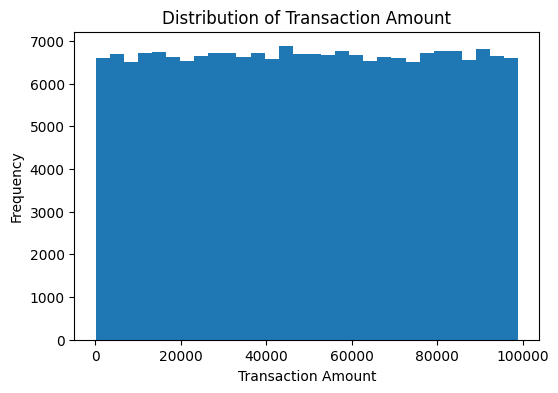


Transaction_Type counts:
Transaction_Type
Credit          40180
Debit           40050
Bill Payment    40040
Transfer        39953
Withdrawal      39777
Name: count, dtype: int64


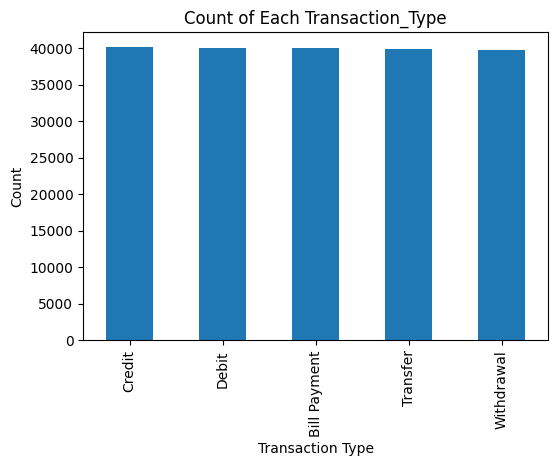

In [13]:

# ==============================================
# 3. Basic Data Inspection & Exploratory Analysis
# ==============================================
print("Shape of the dataset:", df.shape)
print("\nData Types:")
print(df.dtypes)

print("\nChecking for missing values:")
print(df.isnull().sum())

# A quick distribution check for the target variable 'Is_Fraud'
fraud_counts = df['Is_Fraud'].value_counts()
print("\nFraud Class Distribution:")
print(fraud_counts)

# 3.1 Example of basic EDA: Transaction Amount distribution
plt.figure(figsize=(6,4))
plt.hist(df['Transaction_Amount'].dropna(), bins=30)
plt.title("Distribution of Transaction Amount")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

# 3.2 Another example: Check distribution of Transaction_Type
# (Optional - only if you'd like a quick glance at the categories)
print("\nTransaction_Type counts:")
print(df['Transaction_Type'].value_counts())

plt.figure(figsize=(6,4))
df['Transaction_Type'].value_counts().plot(kind='bar')
plt.title("Count of Each Transaction_Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()



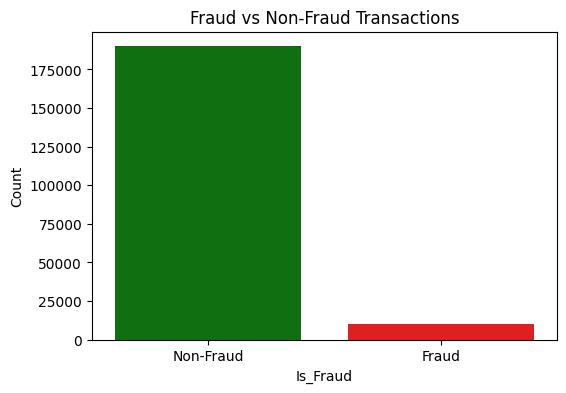

In [14]:
import seaborn as sns
fraud_count = df['Is_Fraud'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_count.index, y=fraud_count.values, palette=['green', 'red'])
plt.title("Fraud vs Non-Fraud Transactions")
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.ylabel("Count")
plt.show()

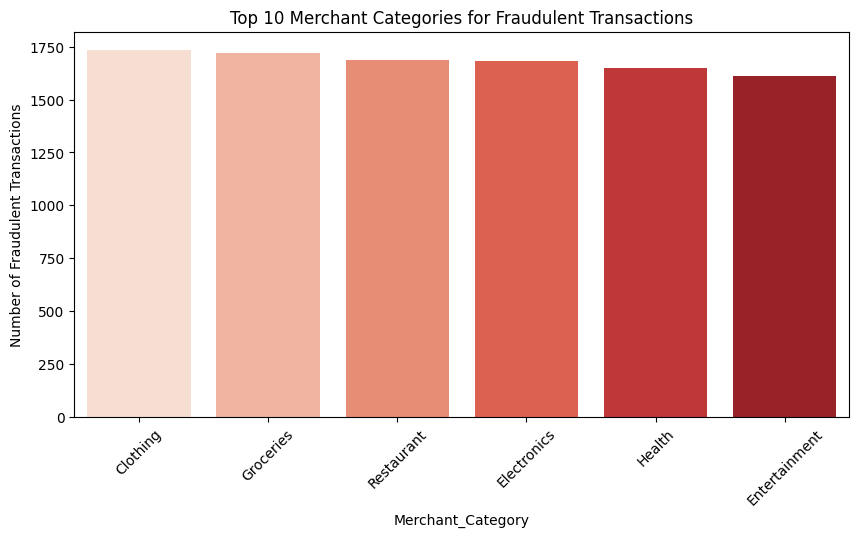

In [15]:
# Fraud by merchant category
fraud_merchant = df[df['Is_Fraud'] == 1]['Merchant_Category'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=fraud_merchant.index, y=fraud_merchant.values, palette='Reds')
plt.title("Top 10 Merchant Categories for Fraudulent Transactions")
plt.xticks(rotation=45)
plt.ylabel("Number of Fraudulent Transactions")
plt.show()

In [16]:
# Encode categorical variables
le = LabelEncoder()
categorical_columns = ['Gender', 'State', 'City', 'Bank_Branch', 'Account_Type', 'Transaction_Device', 'Device_Type', 'Merchant_Category', 'Transaction_Location']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Standardize numerical features
scaler = StandardScaler()
numerical_columns = ['Age', 'Account_Balance']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report

# --- Feature Selection ---
features = ['Gender', 'Age', 'State', 'City', 'Bank_Branch', 'Account_Type', 'Transaction_Device', 
            'Device_Type', 'Merchant_Category', 'Transaction_Location', 'Account_Balance']
target = 'Is_Fraud'

X = df[features]
y = df[target]

# Split data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling (Only fit on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE (Only on training set)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- Model Training ---
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



Logistic Regression Performance:
Accuracy: 0.511525
              precision    recall  f1-score   support

           0       0.95      0.51      0.67     37982
           1       0.05      0.50      0.09      2018

    accuracy                           0.51     40000
   macro avg       0.50      0.51      0.38     40000
weighted avg       0.91      0.51      0.64     40000


Decision Tree Performance:
Accuracy: 0.88485
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     37982
           1       0.05      0.07      0.06      2018

    accuracy                           0.88     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.90      0.88      0.89     40000


Random Forest Performance:
Accuracy: 0.947375
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37982
           1       0.08      0.00      0.01      2018

    accuracy                        

In [33]:
import plotly.express as px

models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [51.15, 88.48, 94.73]

# Create the bar chart
fig = px.bar(x=models, y=accuracies, labels={'x': 'Models', 'y': 'Accuracy'},
             title="Performance of the models", text=accuracies)

# Customize the layout (optional)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside', marker_color='green')

# Show the plot
fig.show()